# Previsão de Diabetes

## Introdução

 Este é um problema classico de classificação na area de ciência de dados. Usar dados de exames de pacientes para prever a ocorrencia de diabetes.
 
 Usaremos um famoso data set, disponibilizado no site lemonade, que contém dados sobre mulheres indianas, como nível de insulina, glicose, idade e quantidade de filhos. E neste projeto usaremos estes dados para prever se determinada paciente tem diabetes ou não. Iremos abordar aqui tecnicas de limpeza de outliers, cross-validation e otimização de hiperparâmetros. Segue abaixo as principais informações sobre o data set, mostrando a variável, informação sobre a variável e tipo dos dados.
 
Pregnancies:
 - Número de vezes grávida
 - Numérico

Glucose:
 - Concentração plasmática de glicose por 2 horas em teste oral de tolerância à glicose
 - Numérico

BloodPressure:
 - Pressão arterial diastólica (mm Hg)
 - Numérico

SkinThickness:
 - Espessura da dobra da pele do tríceps (mm)
 - Numérico

Insulin:
 - 2-Hour serum insulin (mu U/ml)
 - Numérico

BMI:
 - Índice de massa corporal (peso em kg / (altura em m)^2)
 - Numérico

DiabetesPedigreeFunction:
 - Função de pedigree de diabetes
 - Numérico

Age:
 - Idade (em anos)
 - Numérico

class (Outcome):
 - Class variable (0 or 1) 268 of 768 are 1, the others are 0
 - Categórico

Segue abaixo o link do data set:

 Links:
 
 - https://docs.lemonade.org.br/pt-br/spark/base-de-dados/

## Bibliotecas

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Binarizer, MaxAbsScaler, PowerTransformer, Normalizer, Binarizer, QuantileTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from catboost import CatBoostClassifier
from skopt import gp_minimize, dummy_minimize
from skopt.plots import plot_convergence
from matplotlib.pyplot import figure
from PIL import Image
from IPython.display import display, Image
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from matplotlib.pyplot import figure
from sklearn import metrics

## Análise Exploratória dos Dados

 Vamos carregar os dados, já nomeando cada coluna com seu respectivo nome citado nas informações acima.

In [2]:
warnings.filterwarnings("ignore")

nomes = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
dados = pd.read_csv("diabetes.csv")
dados.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


 Temos um total de 768 registros dos dados.

In [3]:
len(dados)

768

 Veja que o python reconheceu as variáveis Pregnancies e Age como variáveis de números inteiros e as demais como números reais. Tudo isto está correto em relação as informações originais do data set, com exceção da variável Outcome. Mas não precisamos converte-la para categórica pois os modelos do sklearn não aceitam variáveis target do tipo categórico e mesmo se aceitassem isto não faria diferença no resultado final.

In [4]:
dados.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

 Não temos nenhum valor missing no data set. Como não sou da área de saúde vou supor que todos os dados estão corretos.

In [5]:
dados.isnull().values.any()

False

 Perceba que além de não termos valores missing, também não temos valores duplicados

In [6]:
dados.duplicated().any()

False

 Aqui temos algumas analises estatísticas de cada variável.
 
 Incrivelmente temos um valor máximo em Pregnancies igual a 17, ou seja, uma mulher com 17 filhos. Mas perceba que este dado se afasta muito da média de 3.8, somando ao fato do desvio padrão ser de apenas 3.36. Além disto, um BMI máximo de 67, duas vezes maior que a média, provavelmente de uma mulher obesa. Veja também que temos mulheres das mais variadas idades, partindo de 21 até 81.
 
 Insulin e DiabetesPedigreeFunction muito provavelmente devem conter outliers, pois seu valor máximo se desvia muito da média somada aos respectivos desvios padrão.
 
 Variável Outcome tem como valores possíveis apenas 0 e 1. Mas sua média é de 0.34, indicando que temos um desbalanceamento dos dados(ideal seria média igual a 0.5).

In [7]:
dados.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Análise Gráfica dos Dados

 Vamos começar primeiramente observando a relação entre a variável target Outcome com as outras. Para isto iremos plotar a média de diabetes agrupada por cada variável. Por exemplo, para variável Age, analisaremos a média de diabetes pela idade da mulher. Tal média será representada pela cor vermelha nos gráficos.
 
 Mas perceba que estas linhas em vermelho inicialmente não parecem fazer sentido quando as olhamos. Para facilitar a visualização, utilizaremos a regressão linear destas médias(reta preta) para descobrirmos se existe uma relação e tendência das variaveis preditivas com a variável target.
 
 Com exceção da variável Age, todas as outras tem clara relação com diabetes. Em BMI, podemos imaginar que obesidade está correlacionada com diabetes. E talvez o mais interessante é que na variável Pregnancies, temos que quanto maior o número de filhos, maior as chances da mulher ter diabetes

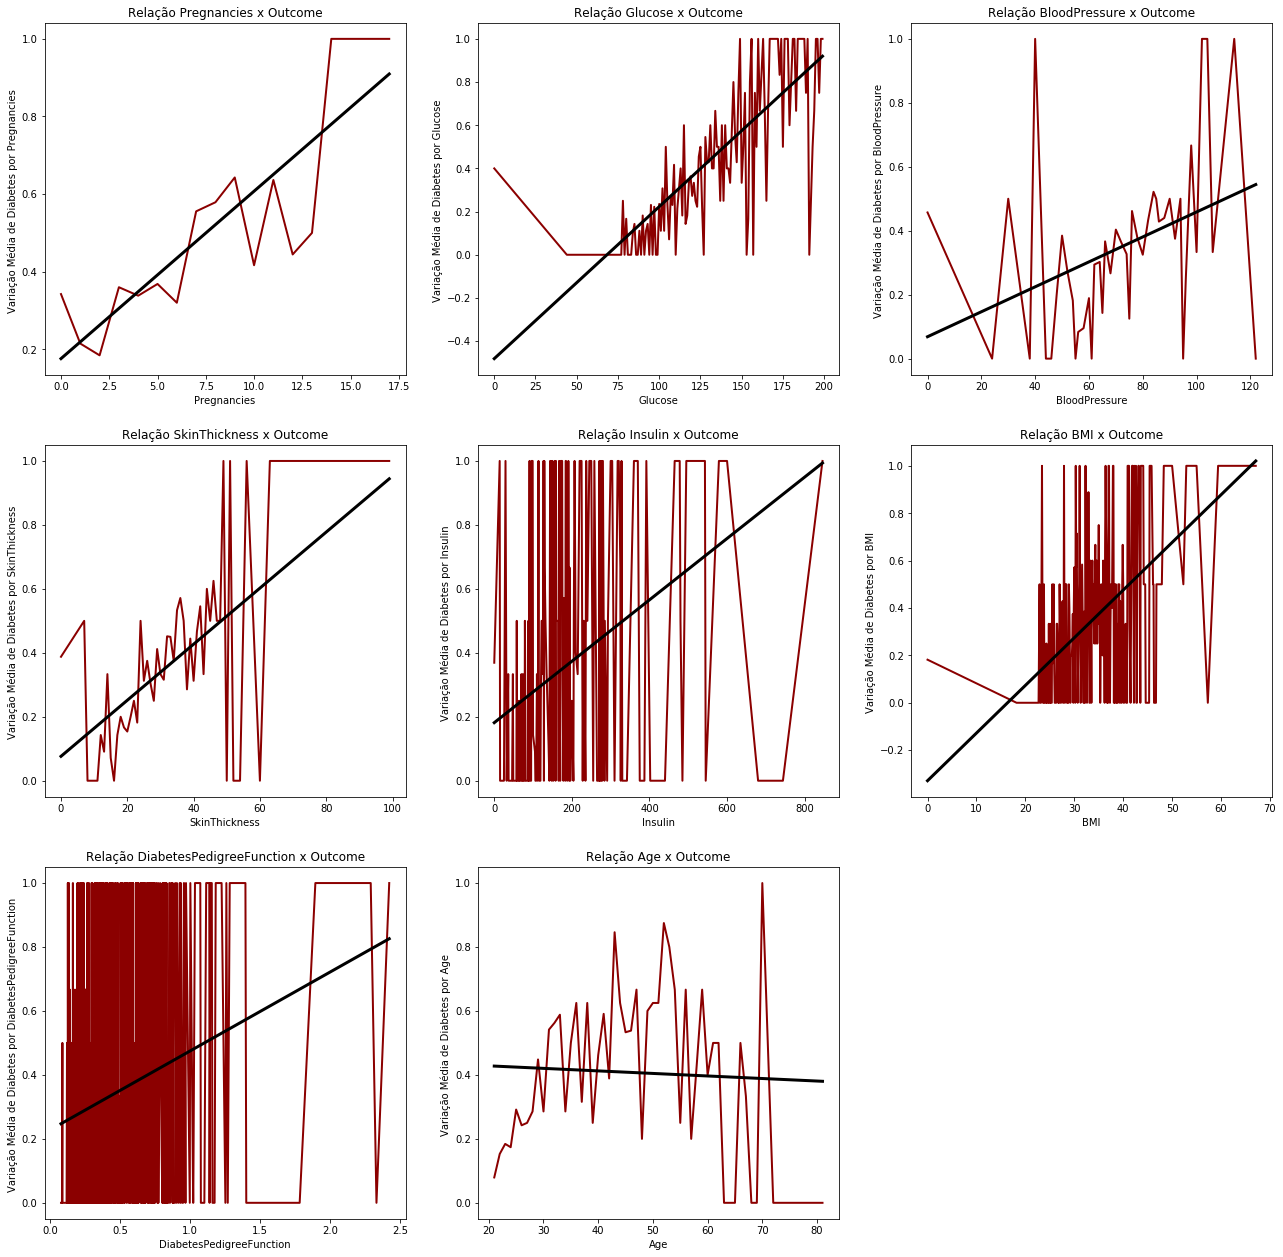

In [8]:
def relacao_media():
    fig, ax = plt.subplots(3, 3, figsize=(22,22))
    count = 0
    for i in [0, 1, 2]:
        for j in [0, 1, 2]:
            idade_media = dados.groupby([nomes[count]]).apply(lambda x: x.mean())

            regressao_linear = LinearRegression().fit(idade_media[nomes[count]].values.reshape(-1,1), idade_media.Outcome.values.reshape(-1,1))
            regressao_linear_previsao = regressao_linear.predict(idade_media[nomes[count]].values.reshape(-1,1))

            ax[i,j].plot(idade_media.Outcome, linewidth = 2, color = "darkred")
            ax[i,j].plot(idade_media[nomes[count]], regressao_linear_previsao, color = "black", linewidth = 3)
            ax[i,j].set_title("Relação %s x Outcome" %(nomes[count]))
            ax[i,j].set_xlabel(nomes[count])
            ax[i,j].set_ylabel("Variação Média de Diabetes por %s " %(nomes[count]))
            count += 1

    fig.delaxes(ax[2,2])
    plt.show()

relacao_media()

### Criação de Variáveis

Vamos aproveitar para criar outras duas novas variáveis a partir de combinações das variáveis que temos. Uma delas será a Age_Pregnancies, definida pelo produto das variáveis Age e Pregnancies. Quanto maior a idade e número de filhos a mulher tiver, maior será o valor desta variável.
 
 A outra variável criada é formada pelo produto das variáveis BMI e BloodPressure. Ou seja, quanto maior a pressão sanguinea e mais obesa for a mulher, maior será o valor desta variável.
 
 Ambas as variáveis serão divididas por 100, logo terão tipo float. Iremos então adicionar estas duas variáveis ao nosso conjunto de dados.

In [9]:
dados["Age_Pregnancies"] = dados.Age * dados.Pregnancies / 100
dados["BMI_BloodPressure"] = dados.BMI * dados.BloodPressure / 100

nomes = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Age_Pregnancies", "BMI_BloodPressure", "Outcome"]
dados = dados[nomes]
dados

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Age_Pregnancies,BMI_BloodPressure,Outcome
0,6,148,72,35,0,33.6,0.627,50,3.00,24.192,1
1,1,85,66,29,0,26.6,0.351,31,0.31,17.556,0
2,8,183,64,0,0,23.3,0.672,32,2.56,14.912,1
3,1,89,66,23,94,28.1,0.167,21,0.21,18.546,0
4,0,137,40,35,168,43.1,2.288,33,0.00,17.240,1
...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,6.30,25.004,0
764,2,122,70,27,0,36.8,0.340,27,0.54,25.760,0
765,5,121,72,23,112,26.2,0.245,30,1.50,18.864,0
766,1,126,60,0,0,30.1,0.349,47,0.47,18.060,1


#### Violin Plots

 Nossos proximos gráficos serão os violinos. Claramente podemos notar presença de outliers, como por exemplo, na variável Skinthickness, onde existe uma linha saindo da extremidade do corpo do violino quando Outcome == 1. O mesmo também vale para as variáveis DiabetesPedigreeFunction e BMI_BloodPressure.
 
 Na variável Glucose, as extremidades inferiores talvez não sejam outliers, pois contem uma pequena quantidade de corpo nas linhas. Mais a frente aplicaremos o z-score para a remoção de outliers e as linhas que saem das extremidade irão sumir.
 
 Perceba que em Age, a média do violino laranja é maior que a média do violono azul(Outcome == 0), indicando que mulheres com maior idade são mais propensas a adquirir diabetes.
 
 Na maioria dos violinos temos uma distribuição com assimetria positiva.

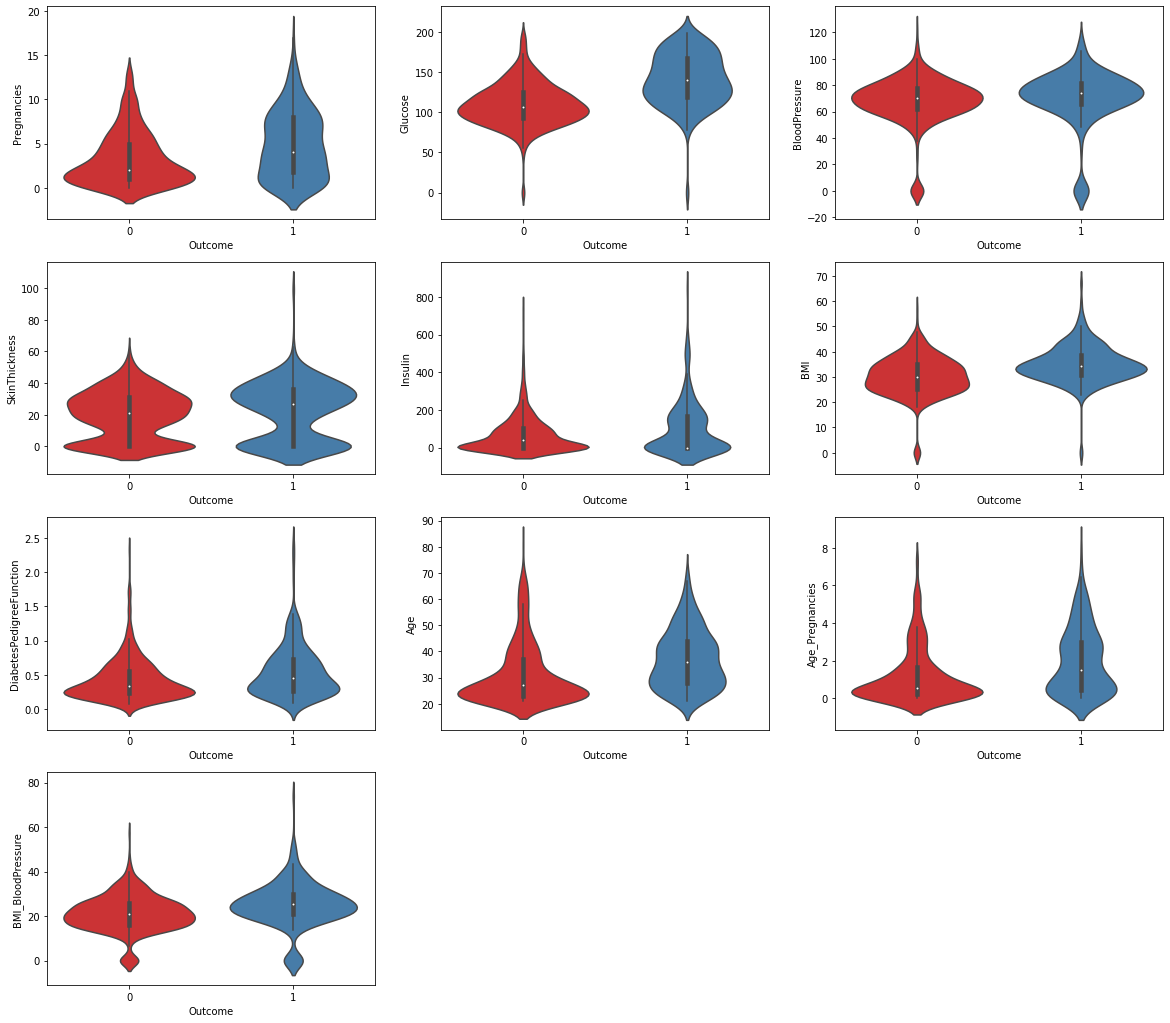

In [10]:
def graficos_violinos(d = dados):
    fig, ax = plt.subplots(4, 3, figsize=(20,18))
    violinos = nomes.copy()
    violinos.remove("Outcome")

    c = 0
    for i in [0, 1, 2, 3]:
        for j in [0, 1, 2]:
            try:
                sns.violinplot(data = d, x = "Outcome", y = violinos[c], ax = ax[i][j], palette = "Set1")

                c += 1
            except:
                pass
    fig.delaxes(ax[3, 1])
    fig.delaxes(ax[3, 2])
    fig.show()

graficos_violinos()

#### Pair Plots

 No pairplot temos a relação entre cada variável, junto com uma regressão linear para observamos a tendência, seus respectivos histogramas e tudo isto separado pela variável Outcome.
 
 Observe as colunas Glucose, BloodPresure e SkinThickness. Todas elas apresentam uma distribuição riom em torno da reta de regressão. Isto deve-se ao fato da presença dos outliers. Em relação aos histogramas, alguns apresentam uma distribuição parecida com a normal e outros uma distribuição positivamente assimétrica.
 
 Veja a relação entre BMI(no eixo x) e Age. Para as mulheres sem diabetes, quanto maior a idade maior o BMI, oque é um tanto quanto intuitivo. Mas para mulheres com diabetes, o BMI tende a ser maior em mulheres mais jovens, ou seja, mulheres mais jovens com BMI alto tendem a ser mais propensas a diabetes. Isto é só uma hipotse. E a mesma relação vale para Glucose(eixo x) e Pregnancies, onde ambas tem correlação positiva para mulheres sem diabetes e aparentemente negativa par a mulheres com diabetes.

<Figure size 720x1440 with 0 Axes>

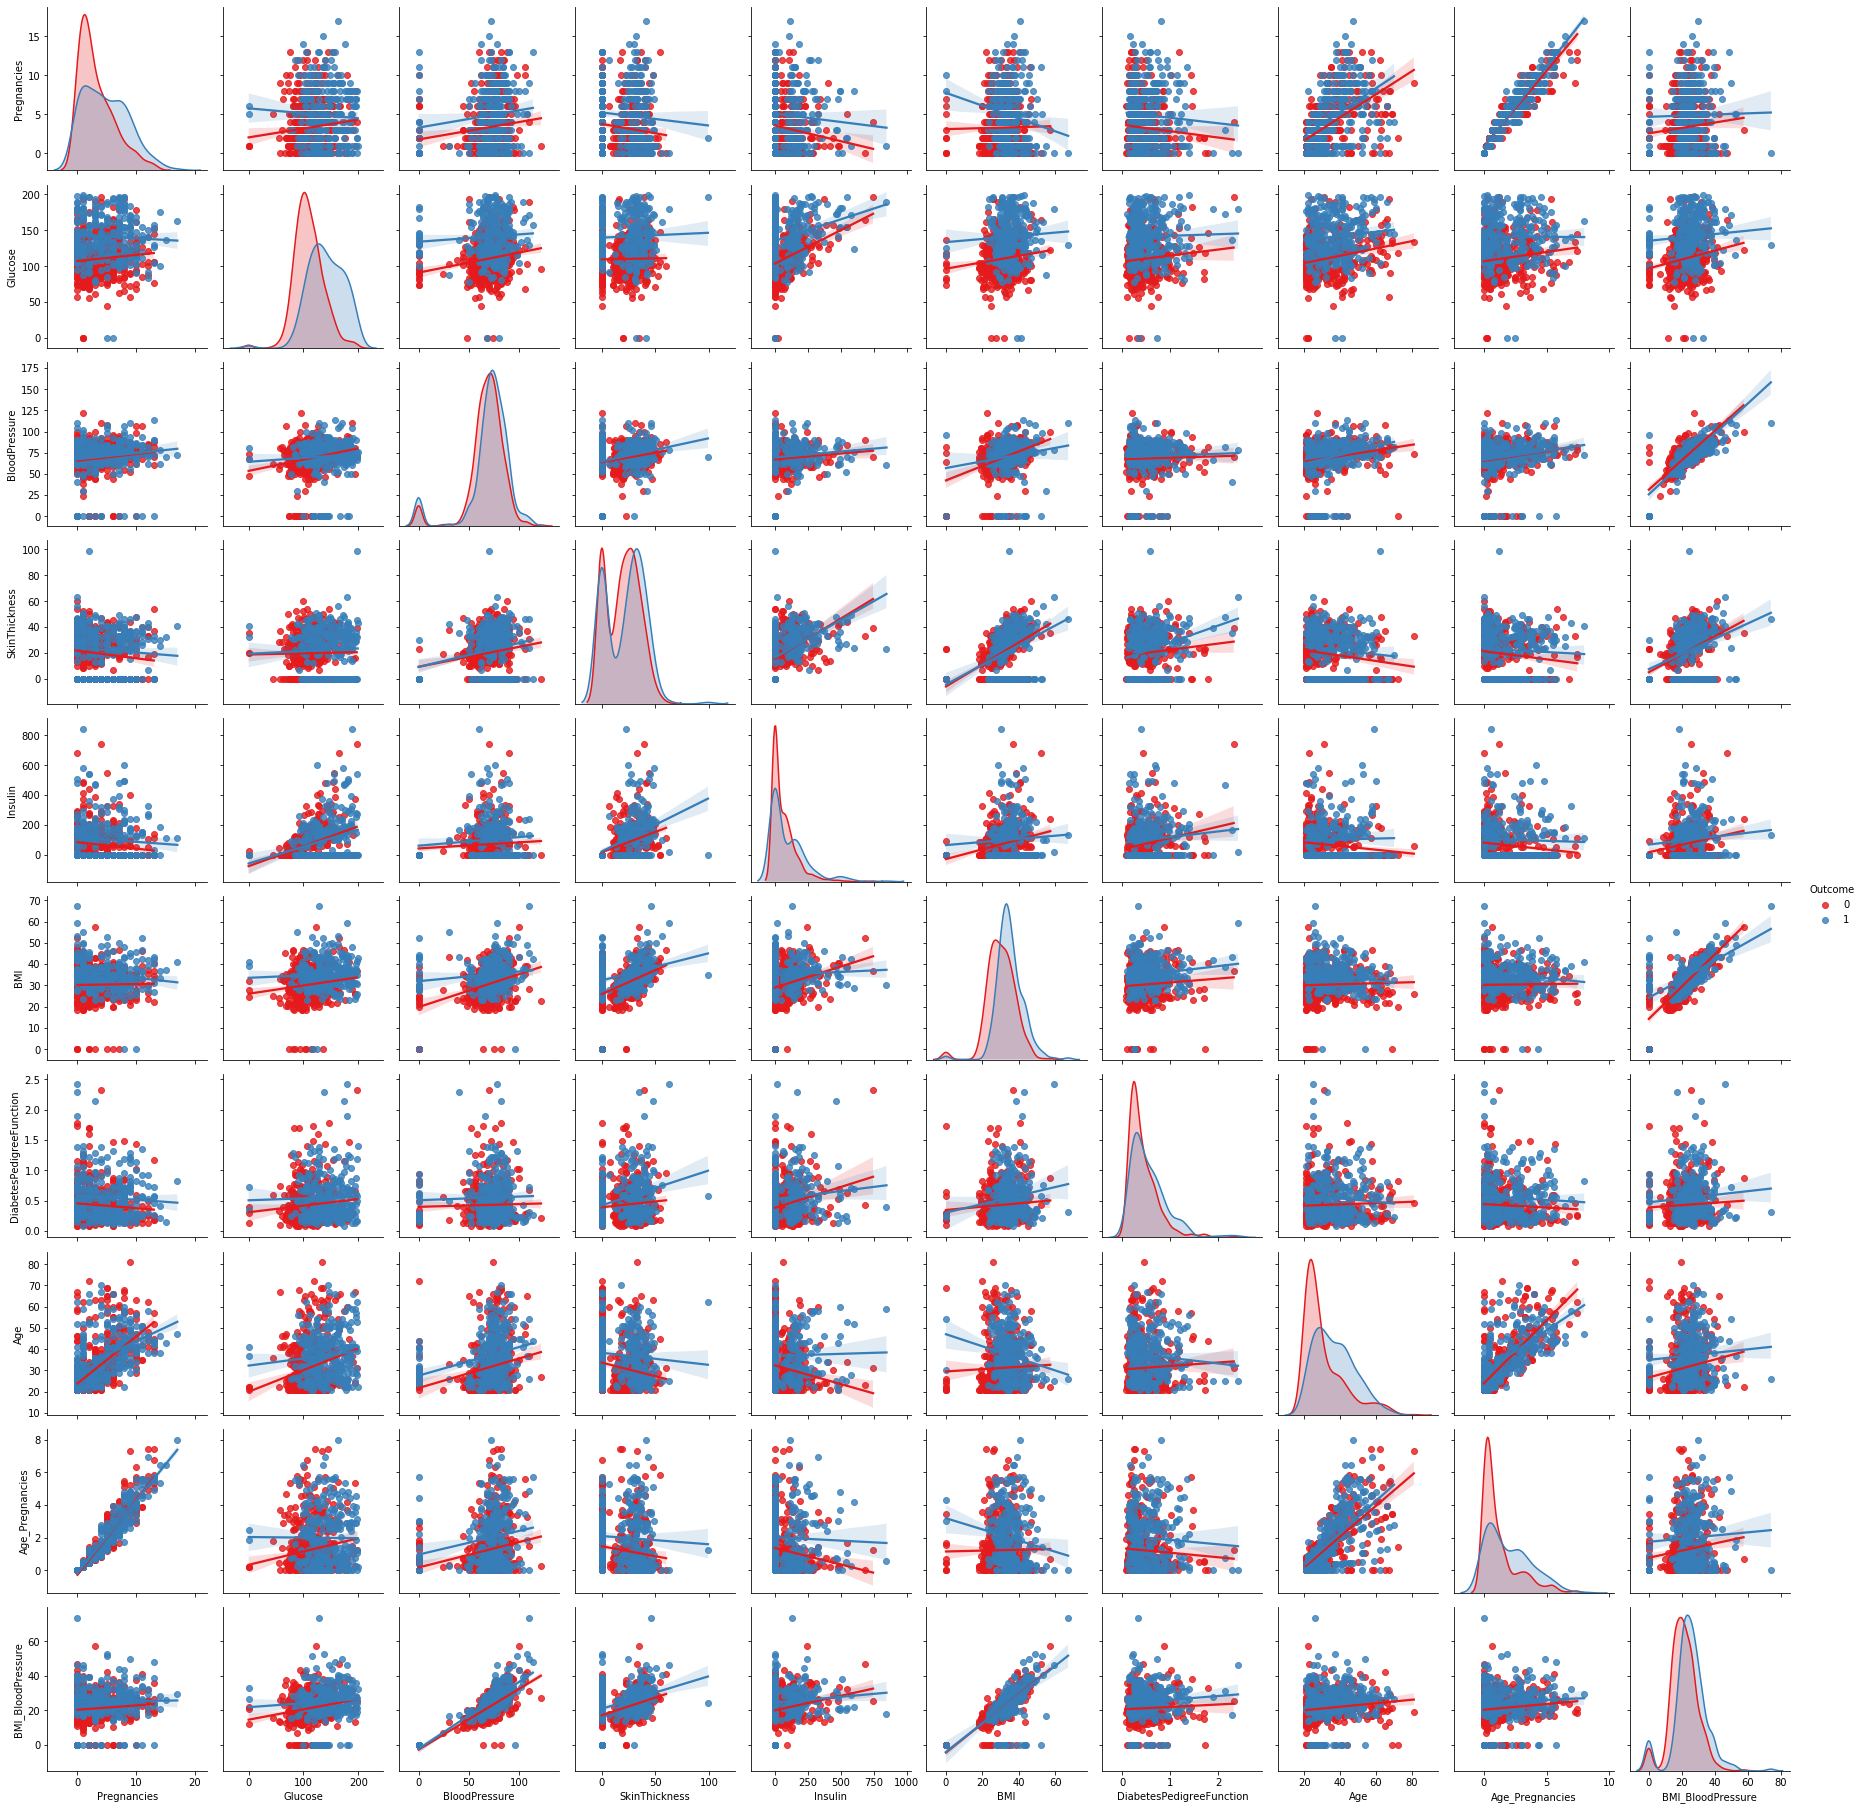

In [11]:
def pair(d = dados):
    plt.figure(figsize=(10,20))
    g = sns.pairplot(d, kind = "reg", hue = "Outcome", palette = "Set1")
    plt.show()

pair()

## Perspectiva da Mãe

 Antes de partirmos para a formatação da escala dos dados, divisão e treino de modelos, vamos analisar os nossos dados por uma outra perspectiva. Note que anteriormente analisamos nossos dados em função da variável Outcome, ou seja, mulheres que tinham ou não diabetes, representadas pelas cores laranja e cinza respectivamente. Mas perceba que existe uma outra variável que podemos subdividi-la em dois grupos, a variável Pregnancies. Tal variável representa a quantidade de filhos que as mulheres do data set tem. De qualquer forma, podemos reduzir este conjunto em duas classes: mulheres que não tem filhos e mulheres que tem filho(s), ambos respectivamente representados por 0 e 1.

In [12]:
dados_pregnance = dados.copy()
dados_pregnance["Pregnancies"] = np.where(((dados_pregnance['Pregnancies'] == 0)), 0, 1)
dados_pregnance.groupby("Pregnancies").BMI.count()

Pregnancies
0    111
1    657
Name: BMI, dtype: int64

#### Violinos

 Observe agora que os gráficos de violinos tem duas dependencias, Outcome e Pregnancies. Além disto, cada linha tracejada representa os quartis dos dados. E algumas informações interessantes podem ser retiradas dos graficos abaixo. Talvez a mais relevante seja na variável Age. Perceba que o fato da não ter filhos, não necessariamente indica que a mulher tem diabetes ou não. Porém, para mulheres que tem filhos, a idade média de mulheres que tem diabetes é maior para mulheres que não tem diabetes. Talvez isto se deva ao fato de que mulheres que tem filhos são mais velhas.

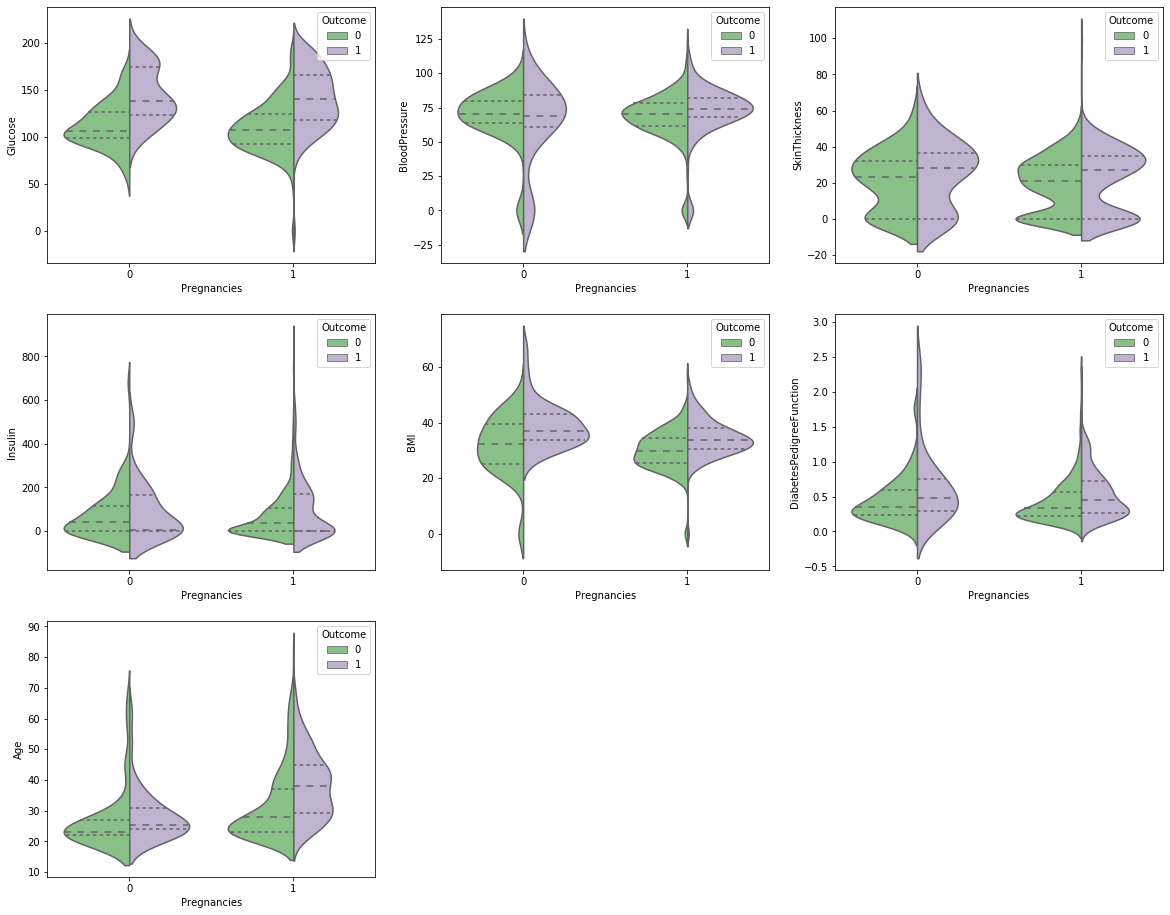

In [13]:
def graficos_violinos1():
    fig, ax = plt.subplots(3, 3, figsize=(20,16))

    violinos = nomes.copy()
    violinos.remove("Pregnancies")
    violinos.remove("Outcome")

    c = 0
    for i in [0, 1, 2]:
        for j in [0, 1, 2]:
            try:
                sns.violinplot(data = dados_pregnance, x = "Pregnancies", y = violinos[c], hue = "Outcome", split = True, palette = "Accent", inner="quartile", ax = ax[i][j])
                c += 1
            except:
                pass

    fig.delaxes(ax[2,1])
    fig.delaxes(ax[2,2])
    fig.show()

graficos_violinos1()

## Correlações

 Nas correlações, temos quatro variáveis que tem alguma correlação positiva com a variável target que são: Pregnancies, Glucoes, BMI e Age, além das variáveis que criamos. Ou seja, a idade da mulher, o número de filhos, indice de massa corporal e idade, todas estas medidas quanto maiores forem, maiores as chances da mulher ter diabetes. Mas isto é apenas uma possibilidade, pois para comprovarmos isto teremos que treinar e testar nossos modelos nestas variáveis.

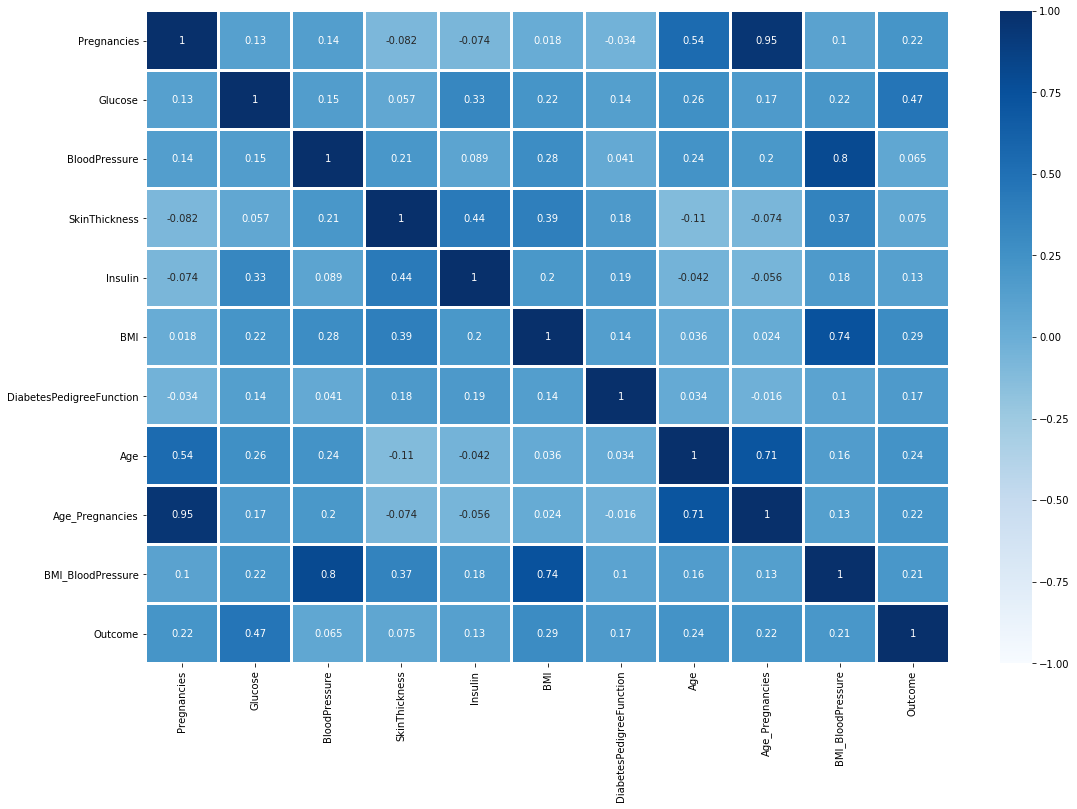

In [14]:
plt.figure(figsize=(18,12))
corr = dados.corr()
sns.heatmap(corr, center = 0, vmin = -1, vmax = 1, annot = True, linewidths = 2, cmap = "Blues")

## Pré-Processamento, Divisão e Balanceamento dos Dados

 Iremos utilizar neste projeto algumas escalas para nossos dados, afim de combinarmos cada uma com modelos preditivos diferentes. Usaremos dados na escala entre 0 e 1(MinMaxScaler), dados em distribuição normal com média 0 e desvio padrão 1(StandardScaler), além de outras escalas como a RobustScaler, que faz o mesmo calculo que a MinMaxScaler, mas com os quartis. Informações de todas elas podem ser encontradas nos dois links abaixos.
 
 Não utilizarei a binarização dos dados.

 Já na parte de divisão dos dados, vamos dividi-los em X_A e X_val(dados de validação), na proporção 9:1. Treinaremos nossos modelos utilizando a técnica do cross-validation em 90% dos dados, além também de otimiza-los. E no final do projeto iremos fazer a previsão para os dados de validação e em seguida todos os dados originais do nosso data set. Vamos também aplicar a mudança de escala nos dados, para podermos aplicar o feature selection, que será explicado abaixo.
 
 Para o balanceamento dos dados iremos utilizar a técnica undersampling, ou seja, iremos remover dados da classe majoritária(neste caso Outcome == 0). Além dos dados serem balanceados antes do treinamento, durante o treinamento no cross-validation também serão balanceados e para isto utilizamos o StratifiedKFold.
 
 Links:
 
 - https://scikit-learn.org/stable/modules/preprocessing.html
 - https://benalexkeen.com/feature-scaling-with-scikit-learn/
 - https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html

In [15]:
Nomes = nomes.copy()
Nomes.remove("Outcome")

X = dados[Nomes].values
Y = dados.Outcome

X_A, X_val_A, Y, Y_val_A = train_test_split(X, Y, test_size = 0.1, random_state = 7)

under_random = RandomUnderSampler(random_state = 7)
X_A, Y = under_random.fit_resample(X_A, Y)

escala_minmax = MinMaxScaler().fit(X_A)
X_B = escala_minmax.transform(X_A)

escala_padronizada = StandardScaler().fit(X_A)
X_C = escala_padronizada.transform(X_A)

escala_robust = RobustScaler().fit(X_A)
X_D = escala_robust.transform(X_A)

escala_maxabs = MaxAbsScaler().fit(X_A)
X_E = escala_maxabs.transform(X_A)

escala_normalizer = Normalizer().fit(X_A)
X_F = escala_normalizer.transform(X_A)

escala_quantile = QuantileTransformer(random_state = 7).fit(X_A)
X_G = escala_quantile.transform(X_A)

Y = Y.values

## 1.0 - Cross Validation

 Aqui temos a parte mais importante do projeto. Primeiramente definimos as métricas que utilizaremos: acurácia, recall e precisão. Então fazemos combinações de diferentes escalas dos dados aplicacos em diferentes números de iterações do modelo catboost e em diferentes variáveis escolhidas pelo SelectKBest(função de feature selection do sklearn, com parâmetros default). Tudo isto é aplicado junto ao cross-validation, utilizando o StratifiedKFold, para não criarmos desbalanceamento nas bases de treino, e com K-Fold = 5. E então convertemos e apresentamos os resultados em um dataframe, onde os valores são ordenados em ordem decrescente em relação a acurácia.
 
 Observe que abaixo temos os melhores resultados encontrados. E o mais interessante é que apenas três variáveis foram suficientes para encontrarmos a melhor acurácia. Além disto, a escala encontrada é a Robust Scaler, seguida pela Quantile Scaler, escalas estas que não vejo com frequência sendo utilizada em publicações.
 
 Talvez o recall e precisão da combinação com melhor acurácia não sejam os melhores, mas são suficientemente bons. Vamos então continuar nosso trabalho utilizando o primeiro resultado do dataframe.
 
 Links:
 
 - https://scikit-learn.org/stable/supervised_learning.html
 - https://scikit-learn.org/stable/modules/feature_selection.html

In [16]:
def cross_val(score_k, cv, iters):
    escala = {"Original": [None, X_A],
              "MinMaxScaler": [preprocessing.MinMaxScaler(feature_range = (0, 1)), X_B],
              "StandardScaler": [preprocessing.StandardScaler(), X_C],
              "RobustScaler": [preprocessing.RobustScaler(), X_D],
              "MaxAbsScaler": [preprocessing.MaxAbsScaler(), X_E],
              "Normalizer": [preprocessing.Normalizer(), X_F],
              "QuantileTransformer": [preprocessing.QuantileTransformer(), X_G]}
    
    metricas = {"acc": "accuracy",
                "rec": "recall",
                "prec": "precision"}
    
    c = 0
    resultados = []
    for esc in escala:
        for K in [10, 9, 8, 7, 6, 5, 4, 3]:
            for iteR in iters:
                modelo = CatBoostClassifier(random_state = 7,
                                            verbose = False,
                                            boosting_type = "Plain",
                                            bootstrap_type = "Bernoulli",
                                            iterations = iteR)

                kbest = SelectKBest(score_k, k = K).fit(escala[esc][1], Y)
                colunas = kbest.get_support(indices = True)
                cross = cross_validate(make_pipeline(escala[esc][0], modelo), X_A[:,colunas], Y, cv = cv.n_splits, scoring = metricas)

                resultados.append(("CatBoostClassifier", esc, K, iteR, (sum(cross["test_acc"]) / cv.n_splits),
                                   (sum(cross["test_rec"]) / cv.n_splits), (sum(cross["test_prec"]) / cv.n_splits)))
                if c % 17 == 0:
                    print(resultados[c])
                c +=1

    return pd.DataFrame(resultados, columns = ["Modelos", "Escala dos Dados", "Variáveis Utilizadas",
                                               "Número de Iterações", "Acurácia Média", "Recall Médio", "Precisão Média"]).sort_values("Acurácia Média", ascending = False)

#results = cross_val(f_classif, StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7), [200, 500, 800])
#results.to_csv("diabetes_cross0.csv", index = False)
results = pd.read_csv("diabetes_cross0.csv")
results.head(56)

,Modelos,Escala dos Dados,Variáveis Utilizadas,Número de Iterações,Acurácia Média,Recall Médio,Precisão Média
0,CatBoostClassifier,RobustScaler,3,800,0.761680,0.801418,0.742896
1,CatBoostClassifier,QuantileTransformer,6,800,0.761657,0.805762,0.740309
2,CatBoostClassifier,MinMaxScaler,3,800,0.759574,0.801418,0.740466
3,CatBoostClassifier,Original,3,800,0.759574,0.801418,0.740466
4,CatBoostClassifier,StandardScaler,3,800,0.759574,0.801418,0.740466
5,CatBoostClassifier,MaxAbsScaler,3,800,0.759574,0.801418,0.740466
6,CatBoostClassifier,QuantileTransformer,3,800,0.759574,0.801418,0.740466
7,CatBoostClassifier,QuantileTransformer,3,200,0.759552,0.805674,0.738539
8,CatBoostClassifier,RobustScaler,3,200,0.759552,0.805674,0.737948
9,CatBoostClassifier,QuantileTransformer,4,800,0.759507,0.797340,0.741209


 Aqui estão as melhores variáveis escolhidas pelo método f_classif que geraram os melhores resultados no cross validation. E de todas as variáveis que tinhamos, incluso as duas que criamos, apenas as variáveis Glucose, BMI e Age foram as que apresentaram os melhores resultados. E isto é otimo pois além de termos encontrado a melhor combinação de variáveis para a melhor média de acurácia, o número baixo destas variáveis vai facilitar o trabalho mais a frente pois agora estamos lidando com bem menos dados que anteriormente caso usássemos todas as variáveis.

In [17]:
def cross_variaveis(r, score_k):
    R = r[r["Acurácia Média"] == r["Acurácia Média"].max()].values[0]
    
    escala = {"Original": [None, X_A],
              "MinMaxScaler": [preprocessing.MinMaxScaler(feature_range = (0, 1)), X_B],
              "StandardScaler": [preprocessing.StandardScaler(), X_C],
              "RobustScaler": [preprocessing.RobustScaler(), X_D],
              "MaxAbsScaler": [preprocessing.MaxAbsScaler(), X_E],
              "Normalizer": [preprocessing.Normalizer(), X_F],
              "QuantileTransformer": [preprocessing.QuantileTransformer()]}
    
    kb = SelectKBest(score_k, k = R[2]).fit(escala[R[1]][1], Y)
    colunas = kb.get_support(indices = True)
    kb = pd.DataFrame(escala[R[1]][1]).iloc[:,colunas]
    
    print("Quantidade de Variáveis Mais Importantes: ", R[2])
    print("Escala dos Dados: ", R[1])
    print("Variáveis Utilizadas:")
    for i in colunas:
        print(Nomes[i])
        
    return kb, colunas

X, colunas = cross_variaveis(results, f_classif)
X.dtypes
X.head(7)

Quantidade de Variáveis Mais Importantes:  3
Escala dos Dados:  RobustScaler
Variáveis Utilizadas:
Glucose
BMI
Age


,1,5,7
0,-0.797814,-0.291105,-0.529412
1,0.972678,1.595687,-0.235294
2,0.579235,1.045822,-0.352941
3,-0.426230,-0.916442,-0.470588
4,-0.710383,-0.894879,-0.470588
5,-0.513661,-1.606469,-0.529412
6,-0.666667,-0.625337,-0.470588


 Perceba que para realizarmos previsões em outros dados quaisquer, devemos alterar a escala dos dados que serão testados, que neste caso são os dados de validação. O código abaixo faz isto automaticamente para todas as escalas que definimos.

In [18]:
def previsao(r, g1 = X_val_A, g2 = Y_val_A, c = colunas):
    R = r[r["Acurácia Média"] == r["Acurácia Média"].max()].values[0]
    
    if R[1] == "MinMaxScaler":
        X_ = escala_minmax.transform(g1)
    
    elif R[1] == "Original":
        X_ = g1
    
    elif R[1] == "StandardScaler":
        X_ = escala_padronizada.transform(g1)
    
    elif R[1] == "RobustScaler":
        X_ = escala_robust.transform(g1)
    
    elif R[1] == "Normalizer":
        X_ = escala_normalizer.transform(g1)
    
    elif R[1] == "MaxAbsScaler":
        X_ = escala_maxabs.transform(g1)
    
    else:
        X_ = escala_quantile.transform(g1)
    
    return pd.DataFrame(X_).iloc[:,c], g2

X_val0, Y_val = previsao(results, X_val_A, Y_val_A, colunas)
val = X_val0.head(7)
X_val0 = X_val0.values
val

,1,5,7
0,-0.666667,-0.636119,-0.352941
1,1.322404,0.301887,1.235294
2,0.688525,-0.679245,0.764706
3,-0.601093,-0.474394,-0.411765
4,0.098361,-0.592992,1.117647
5,0.273224,-0.021563,0.529412
6,-0.273224,-0.646900,-0.352941


### 1.1 - Otimização

 Vamos então otimizar os hiperparâmetros do modelo CatBoostClassifier aplicados nos melhores dados de treinamento selecionados no cross-validation. E como este modelo é muito sofisticado, temos a opção de otimizar muitos hiperparâmetros. EU particularmente prefiro modelos como estes pois temos uma maior chance de otimiza-lo, mesmo que isto leve um tempo maior.
 
 No gráfico abaixo temos a acurácia negativa(para aumentar a métrica, devemos minimizar o seu valor negativo) pelo número de iterações da otimização. Mostraremos, na parte das previsões, os hiperparâmetros escolhidos pela otimização.
 
 Se quiser saber sobre mais detalhes do código da otimização, sugiro os links abaixo.
 
 Links:
 
 - https://www.youtube.com/watch?v=WhnkeasZNHI&t
 - https://catboost.ai/docs/concepts/python-usages-examples.html
 - https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list

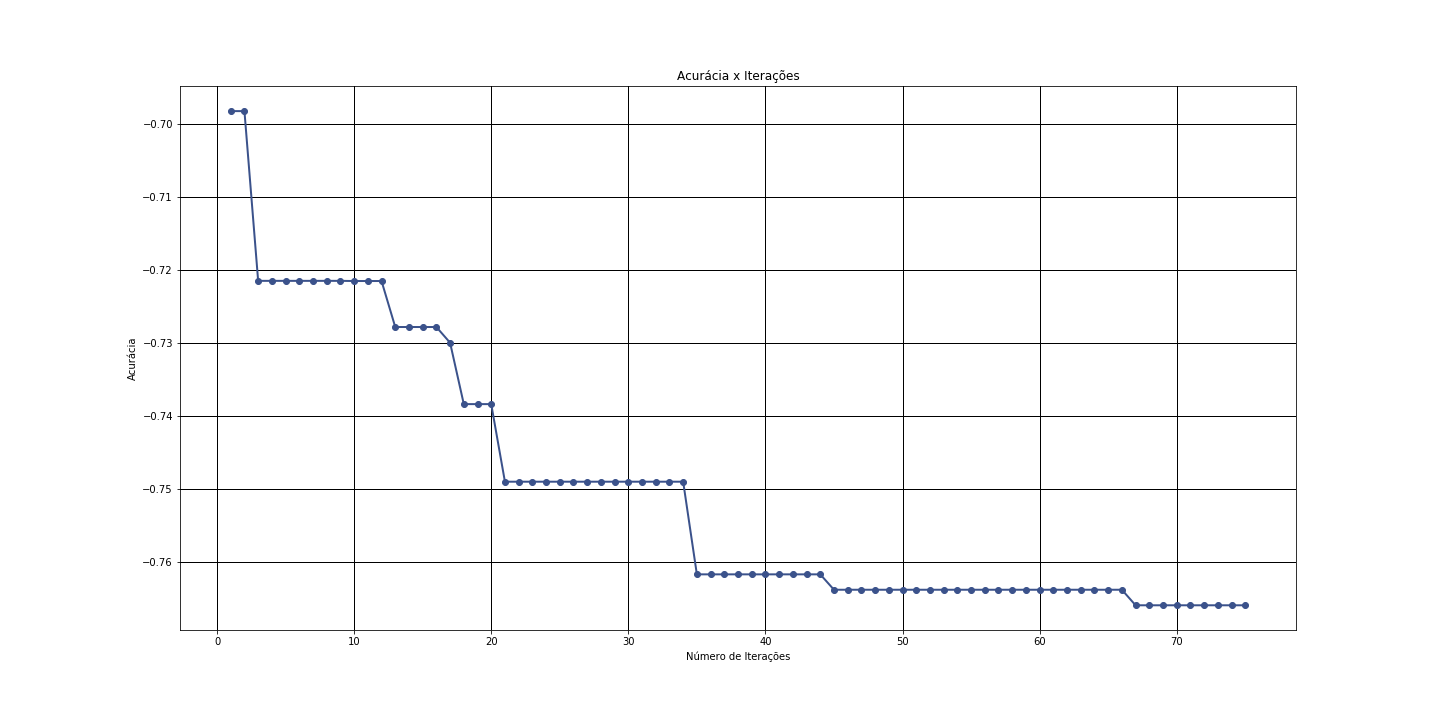

In [19]:
def minimizar_catc(params, r = results):
    learning_rate = params[0]
    l2_leaf_reg = params[1]
    depth = params[2]
    iterations = params[3]
    od_type = params[4]
    random_strength = params[5]
    od_wait = params[6]
    
    #print(params)
    
    modelo = CatBoostClassifier(random_state = 7,
                                verbose = False,
                                learning_rate = learning_rate,
                                l2_leaf_reg = l2_leaf_reg,
                                depth = depth,
                                iterations = iterations,
                                od_type = od_type,
                                random_strength = random_strength,
                                od_wait = od_wait,
                                boosting_type = "Plain",
                                bootstrap_type = "Bernoulli")
    
    R = r[r["Acurácia Média"] == r["Acurácia Média"].max()].values[0]
    
    escala = {"Original": None,
              "MinMaxScaler": preprocessing.MinMaxScaler(feature_range = (0, 1)),
              "StandardScaler": preprocessing.StandardScaler(),
              "RobustScaler": preprocessing.RobustScaler(),
              "MaxAbsScaler": preprocessing.MaxAbsScaler(),
              "QuantileTransformer": preprocessing.QuantileTransformer()}
    
    metricas = {"acc": "accuracy"}
    
    resultados = cross_validate(make_pipeline(escala[R[1]], modelo), X, Y, cv = 5, scoring = metricas)
    
    return - sum(resultados["test_acc"]) / 5


espaco = [(0.0001, 1.0),
          (1, 9),
          (4, 10),
          (600, 1000),
          ("IncToDec", "Iter"),
          (0.01, 10.0),
          (10, 30)]

#resultados_otimizacao = gp_minimize(minimizar_catc, espaco, random_state = 1, n_calls = 75, n_random_starts = 10, verbose = False)

def iteracoes():
    figure(figsize = (20,10))
    resultados_otimizacao.func_vals[0] = resultados_otimizacao.func_vals[1]
    plot_convergence(resultados_otimizacao)
    plt.title("Acurácia x Iterações")
    plt.xlabel("Número de Iterações")
    plt.ylabel("Acurácia")
    plt.grid(color = 'black', linestyle = '-', linewidth = 1)
    plt.savefig('imagem_catc.png')
    plt.show()
    
#iteracoes()
    
display(Image(filename='imagem_catc.png')) 

### 1.2 - Previsões

 Agora que temos nosso modelo treinado e otimizado em função da acurácia, vamos então realizar algumas previsões.

#### Dados de Validação

 Primeiramente vamos prever os dados de validação definidos anteriormente e com devidas escalas e variáveis selecionadas. Lembre-se que os dados de validação que definimos são apenas 10% dos dados tratados e balanceados. E por ser uma quantidade baixa, as previsões podem variar muito de uma para outra. Vale ressaltar também que se este fosse um projeto para entregar no trabalho, ou oferecer serviços com isto, não dividiriamos os dados em treino e validação, mas sim fazer todo o treinamento com todos os dados tratados e balanceados disponíveis. Quanto mais dados para trabalhar, melhor.
 
 Em nossa primeira previsão, veja que nosso modelo está com boa acurácia e recall, que era justamente as métricas mais importantes em problemas em data science na área da saúde. Além disto o score da curva ROC está muito bom.

________________________________________________________________MODELO OTIMIZADO APLICADO NOS DADOS DE VALIDAÇÃO:
________________________________________________________________ACURÁCIA:  0.7792207792207793
________________________________________________________________RECALL:  0.9032258064516129
________________________________________________________________PRECISÃO:  0.6666666666666666
________________________________________________________________F1:  0.7671232876712328
________________________________________________________________SELETIVIDADE:  0.6956521739130435
________________________________________________________________NPV:  0.9142857142857143


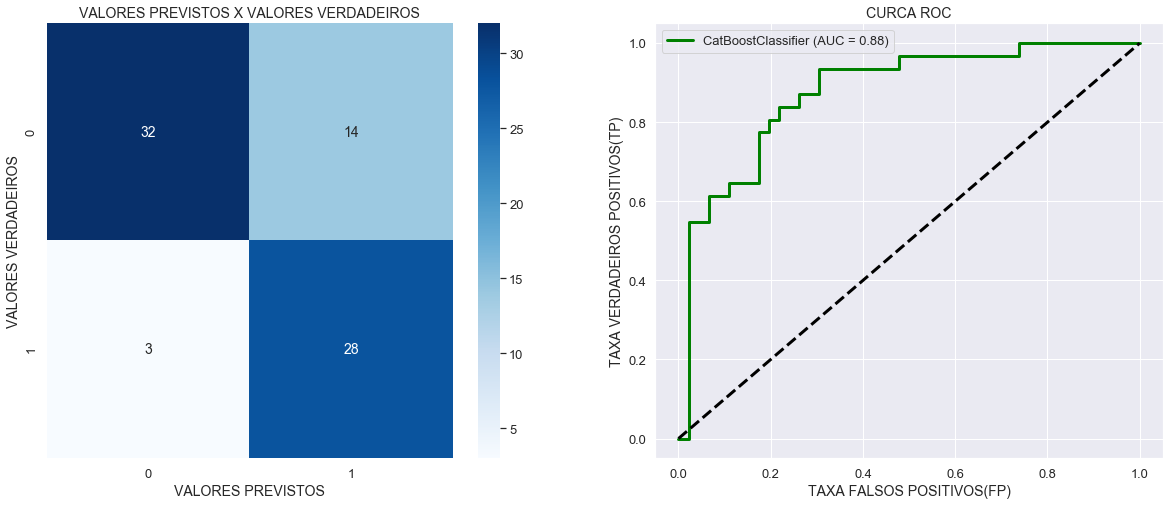

In [20]:
def modelos(modelo, Xtreino, Ytreino, Xteste, Yteste):
    sns.set(font_scale = 1.175)
    modelo.fit(Xtreino, Ytreino)
    
    valores_previstos = modelo.predict(Xteste)
        
    matriz = confusion_matrix(Yteste, valores_previstos)
    tn, fp, fn, tp = matriz.ravel()
    
    metricas = [accuracy_score(Yteste, valores_previstos),
                recall_score(Yteste, valores_previstos),
                precision_score(Yteste, valores_previstos),
                f1_score(Yteste, valores_previstos),
                tn / (tn + fp),
                tn / (tn + fn)]
    
    print("________________________________________________________________ACURÁCIA: ", metricas[0])
    print("________________________________________________________________RECALL: ", metricas[1])
    print("________________________________________________________________PRECISÃO: ", metricas[2])
    print("________________________________________________________________F1: ", metricas[3])
    print("________________________________________________________________SELETIVIDADE: ", metricas[4])
    print("________________________________________________________________NPV: ", metricas[5])
    
    fig, ax = plt.subplots(figsize = (20, 8), nrows = 1, ncols = 2)
    sns.heatmap(matriz, annot = True, cmap = "Blues", fmt = 'g', ax = ax[0])
    ax[0].set_title("VALORES PREVISTOS X VALORES VERDADEIROS")
    ax[0].set_xlabel("VALORES PREVISTOS")
    ax[0].set_ylabel("VALORES VERDADEIROS")
    
    metrics.plot_roc_curve(modelo, Xteste, Yteste, ax = ax[1], lw = 3, color = "green")
    a = sns.lineplot(x = [0,1], y = [0,1], color = "black", lw = 3, ax = ax[1])
    a.lines[1].set_linestyle("--")
    ax[1].set_title("CURCA ROC")
    ax[1].set_xlabel("TAXA FALSOS POSITIVOS(FP)")
    ax[1].set_ylabel("TAXA VERDADEIROS POSITIVOS(TP)")
    
    plt.show()

arquivo = "modelo_diabetes_catc.sav"
'''
pickle.dump(CatBoostClassifier(random_state = 7,
                                verbose = False,
                                learning_rate = resultados_otimizacao.x[0],
                                l2_leaf_reg = resultados_otimizacao.x[1],
                                depth = resultados_otimizacao.x[2],
                                iterations = resultados_otimizacao.x[3],
                                od_type = resultados_otimizacao.x[4],
                                random_strength = resultados_otimizacao.x[5],
                                od_wait = resultados_otimizacao.x[6],
                                boosting_type = "Plain",
                                bootstrap_type = "Bernoulli"), open(arquivo, 'wb'))
'''
modelo_otimizado0 = pickle.load(open(arquivo, 'rb'))

print("________________________________________________________________MODELO OTIMIZADO APLICADO NOS DADOS DE VALIDAÇÃO:")
modelos(modelo_otimizado0, X, Y, X_val0, Y_val)

### Dados de Treino

 Quando prevemos nossos proprios dados de treino, é normal observarmos uma acurácia alta e aqui neste projeto não é diferente. Mas este não é um bom parametro de avaliação para o nosso modelo já que ele é treinado no proprio conjunto de dados de treino. De qualquer forma, ele se saiu muito bem e não houve uma diferença significativa em relação a previsão anterior sobre os dados de validação que o modelo nunca tinha visto. Isto indica que temos um modelo generalizado.

________________________________________________________________ACURÁCIA:  0.8523206751054853
________________________________________________________________RECALL:  0.890295358649789
________________________________________________________________PRECISÃO:  0.8274509803921568
________________________________________________________________F1:  0.8577235772357723
________________________________________________________________SELETIVIDADE:  0.8143459915611815
________________________________________________________________NPV:  0.8812785388127854


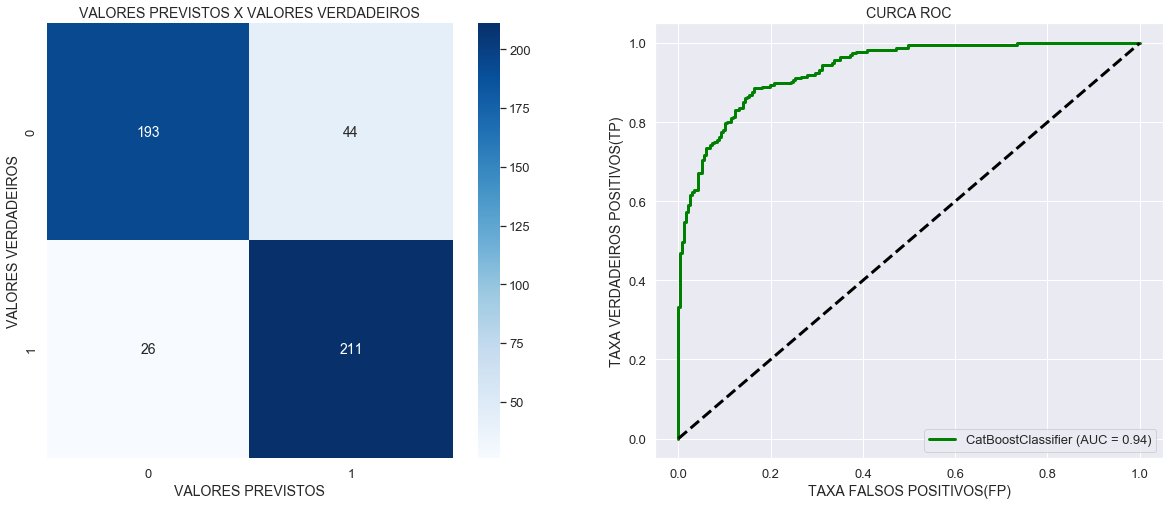

In [21]:
modelos(modelo_otimizado0, X, Y, X, Y)

### Todos os Dados

 Agora faremos previsões sobre todos os dados que temos no arquivo csv, porém com a devida escala.
 
 E analisando as matrizes de confusão das duas previsões dos modelos que foram treinados sobre score accuracy, o score recall e NPV se sobressairam sobre todos os outros apresentados, mas ainda mantivemos boa acurácia. Logo, este é um excelente modelo para fazer previsões neste problema, já que era justamente o recall e acurácia são as métricas mais importantes para este projeto.

________________________________________________________________ACURÁCIA:  0.8059895833333334
________________________________________________________________RECALL:  0.8917910447761194
________________________________________________________________PRECISÃO:  0.6657381615598886
________________________________________________________________F1:  0.7623604465709729
________________________________________________________________SELETIVIDADE:  0.76
________________________________________________________________NPV:  0.9290953545232273


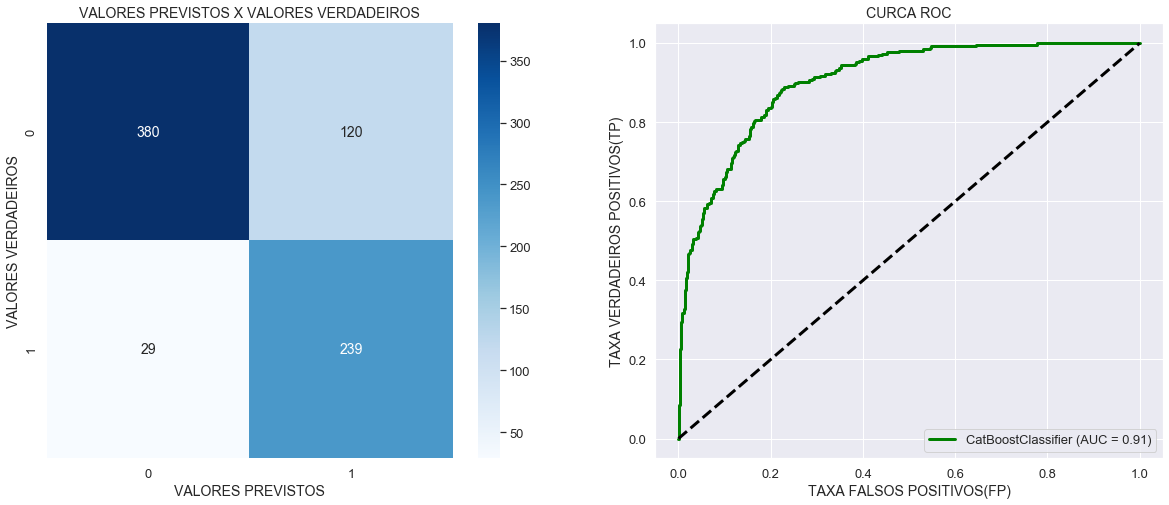

In [22]:
x0, y = previsao(r = results, g1 = dados.loc[:,dados.columns != "Outcome"], g2 = dados.Outcome)
x0 = x0.values
y = y.values

modelos(modelo_otimizado0, X, Y, x0, y)